In [3]:
from fast_rl.core.basic_train import AgentLearner
from fast_rl.agents.dqn import create_dqn_model, dqn_learner, DQNLearner
from fast_rl.agents.dqn_models import *
from fast_rl.core.train import AgentInterpretation, GroupAgentInterpretation
from fast_rl.core.data_block import MDPDataBunch
from fast_rl.core.agent_core import ExperienceReplay, GreedyEpsilon, PriorityExperienceReplay
import torch
from fastai.gen_doc.nbdoc import *
from fastai.basic_data import DatasetType

## Databunch for Training / Validation
For reinforcement learning, training might take a long time.

Note that if you want to avoid validation running, just turn it off and reflect the change in 
the interpretation objects. The agent will train much faster, and then you could validate later.
```python
data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', add_valid=False, bs=128)
AgentInterpretation(learn=learn, ds_type=DatasetType.Train)
```

In [ ]:
data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', bs=32)

In [ ]:
show_doc(DQN.__init__)

In [ ]:
show_doc(BaseDQNCallback.__init__)
show_doc(BaseDQNCallback.on_loss_begin)

The batch size will be defined in the data class because `DataBunches` already require a 
batch size input. This batch size will be used by the model during optimization.

## Experience Replay

In [ ]:
model = DQN(data, memory=ExperienceReplay(memory_size=100000, reduce_ram=True),
           lr=0.00025, optimizer=torch.optim.RMSprop)

In [ ]:
learn = AgentLearner(data, model)
learn.fit(450)
data.close()
learn.recorder.plot_losses()

In [ ]:
interp = AgentInterpretation(learn)

In [ ]:
interp.plot_rewards(cumulative=True, per_episode=True, group_name='er_rms')

We can also pipe-line this to truly see how our model actually performs.

In [ ]:
group_interp = GroupAgentInterpretation()
group_interp.add_interpretation(interp)
for i in range(5):
    data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', bs=32, add_valid=False)
    model = DQN(data, memory=ExperienceReplay(memory_size=1000000, reduce_ram=True),
                lr=0.001, optimizer=torch.optim.RMSprop)
    learn = AgentLearner(data, model)
    learn.fit(450)
    interp = AgentInterpretation(learn, ds_type=DatasetType.Train)
    interp.plot_rewards(cumulative=True, per_episode=True, group_name='er_rms', no_show=True)
    group_interp.add_interpretation(interp)
    group_interp.to_pickle('data/dqn', 'dqn_er_rms')
    data.close()

In [ ]:
group_interp = GroupAgentInterpretation.from_pickle('data/cartpole_dqn', 'dqn_ExperienceReplay_FEED_TYPE_STATE')
group_interp.plot_reward_bounds(per_episode=True, smooth_groups=10)

In [ ]:
[g.analysis for g in group_interp.groups]

## Priority Experience Replay

In [ ]:
per_group_interp = GroupAgentInterpretation()
per_group_interp.add_interpretation(interp)
for i in range(4):
    data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', bs=32)
    model = DQN(data, memory=PriorityExperienceReplay(memory_size=100000, reduce_ram=True))
    learn = AgentLearner(data, model)
    learn.fit(450)
    interp = AgentInterpretation(learn, ds_type=DatasetType.Train)
    interp.plot_rewards(cumulative=True, per_episode=True, group_name='per_rms', no_show=True)
    per_group_interp.add_interpretation(interp)
    group_interp.to_pickle('data/dqn', 'dqn_per')
    data.close()

In [ ]:
per_group_interp = GroupAgentInterpretation.from_pickle('data/cartpole_dqn', 'dqn_PriorityExperienceReplay_FEED_TYPE_STATE')
per_group_interp.add_interpretation(group_interp)
per_group_interp.plot_reward_bounds(per_episode=True, smooth_groups=10)

CartPole envs might be too simple for PER to be effective. We also tested with lunar lander to see if PER improves performance, and noticed that it actually performs worse than ER. There is a possibility that you could increase the random sampling for PER to see if there is an improvement.

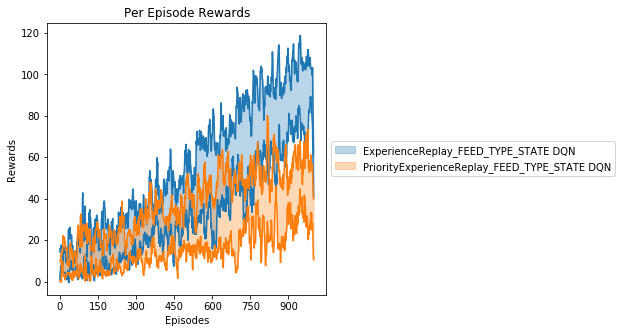

In [4]:
per_group_interp = GroupAgentInterpretation.from_pickle('data/lunarlander_dqn', 'dqn_ExperienceReplay_FEED_TYPE_STATE')
per_group_interp.add_interpretation(
    GroupAgentInterpretation.from_pickle('data/lunarlander_dqn', 'dqn_PriorityExperienceReplay_FEED_TYPE_STATE')
)
per_group_interp.plot_reward_bounds(per_episode=True, smooth_groups=10)

In [ ]:
per_group_interp.analysis